<a href="https://colab.research.google.com/github/JHS530/portfolio2025/blob/main/%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from pathlib import Path

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
base = Path("/content/drive/MyDrive/bike")
files = sorted(base.glob("*.csv"))
len(files), files[:3]

(7,
 [PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2406.csv'),
  PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2407.csv'),
  PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2408.csv')])

In [9]:
files = sorted(base.rglob("*.csv"))
len(files), files[:3]

(7,
 [PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2406.csv'),
  PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2407.csv'),
  PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2408.csv')])

In [10]:
files = sorted(base.glob('*24*.csv'))
len(files), files[:3]

(7,
 [PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2406.csv'),
  PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2407.csv'),
  PosixPath('/content/drive/MyDrive/bike/서울특별시 공공자전거 이용정보(일별)_2408.csv')])

In [11]:
def read_csv_ko(p):
    try:
        return pd.read_csv(p)
    except UnicodeDecodeError:
        return pd.read_csv(p, encoding = "cp949")

# 샘플 읽기
df0 = read_csv_ko(files[0])
df0.head(), list(df0.columns)

(         대여일자  대여소번호                  대여소 대여구분코드   성별   연령대   이용건수    운동량  \
 0  2024-06-01    732           732. 신월중학교    정기권  NaN  ~10대      1  70.43   
 1  2024-06-01    734        734. 신트리공원 입구    정기권  NaN  ~10대      1  45.17   
 2  2024-06-01    735          735. 영도초등학교    정기권  NaN  ~10대      1  14.73   
 3  2024-06-01    947  947. 연신내 선일하이츠빌 정류소    정기권  NaN  ~10대      1   0.00   
 4  2024-06-01    949     949. 연신내역 1번 출구     정기권  NaN  ~10대      1  16.26   
 
     탄소량  이동거리(M)  이용시간(분)  
 0  0.63  2736.36       27  
 1  0.53  2281.41       12  
 2  0.18   791.26        4  
 3  0.00     0.00        2  
 4  0.18   774.62        6  ,
 ['대여일자',
  '대여소번호',
  '대여소',
  '대여구분코드',
  '성별',
  '연령대',
  ' 이용건수',
  '운동량',
  '탄소량',
  '이동거리(M)',
  '이용시간(분)'])

In [48]:
dfs = [read_csv_ko(p) for p in files]
raw = pd.concat(dfs, ignore_index = True)
raw.shape, raw.head(2)

((14391410, 11),
          대여일자  대여소번호            대여소 대여구분코드   성별   연령대   이용건수    운동량   탄소량  \
 0  2024-06-01    732     732. 신월중학교    정기권  NaN  ~10대      1  70.43  0.63   
 1  2024-06-01    734  734. 신트리공원 입구    정기권  NaN  ~10대      1  45.17  0.53   
 
    이동거리(M)  이용시간(분)  
 0  2736.36       27  
 1  2281.41       12  )

In [49]:
raw.columns

Index(['대여일자', '대여소번호', '대여소', '대여구분코드', '성별', '연령대', ' 이용건수', '운동량', '탄소량',
       '이동거리(M)', '이용시간(분)'],
      dtype='object')

In [50]:
# 컬럼명 정규화
raw.columns = (pd.Index(raw.columns)
                .str.strip()
                .str.replace(r"\s+", "", regex = True) # 모든 공백 제거
                .str.replace("\u3000", "", regex = False) # 전각 스페이스
                .str.replace("\xa0", "", regex = False)) # non-breaking space

In [51]:
# 날짜/카운트 컬럼 자동 찾기(정규화된 이름)
date_col_candidates = [c for c in raw.columns if ("일자" in c or "일시" in c)]
count_col_candidates = [c for c in raw.columns if ("이용" in c and "건" in c)]

date_col = date_col_candidates[0]
count_col = count_col_candidates[0]
date_col, count_col

('대여일자', '이용건수')

In [52]:
# 날짜 파싱
raw["date"] = pd.to_datetime(raw[date_col], errors = "coerce")
ratio_nat = raw["date"].isna().mean()

if ratio_nat > 0.5:
    raw["date"] = pd.to_datetime(raw[date_col].astype(str), format = "%Y%m%d", errors = "coerce")

raw = raw.dropna(subset = ["date"])
raw["date"].head()

,date
0,2024-06-01
1,2024-06-01
2,2024-06-01
3,2024-06-01
4,2024-06-01


In [53]:
# 이용건수 숫자화
raw[count_col] = (raw[count_col].astype(str)
                    .str.replace(",", "", regex = False)
                    .str.replace("\u00A0", "", regex = False)
                    .str.replace(" ", "", regex = False))
raw[count_col] = pd.to_numeric(raw[count_col], errors = "coerce")
raw[count_col].head()

,이용건수
0,1
1,1
2,1
3,1
4,1


In [54]:
# 일자별 합산 -> 일 단위 시계열 만들기
daily = raw.groupby("date")[count_col].sum().rename("count")
y = daily.sort_index().asfreq("D").interpolate()
y.shape, y.index.min(), y.index.max()

((214,), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-12-31 00:00:00'))

In [55]:
y.tail()

,count
date,
2024-12-27,68320
2024-12-28,45723
2024-12-29,43608
2024-12-30,79477
2024-12-31,72939


In [56]:
# 홀드아웃(마지막 14일)
valid_days = 14
train_y = y.iloc[:-valid_days]
val_y = y.iloc[-valid_days:]
train_y.shape, val_y.shape

((200,), (14,))

In [57]:
# 베이스라인(어제값, 7일 이동평균)
naive_pred = train_y.shift(1).iloc[-valid_days:]
ma7_pred = train_y.rolling(7).mean().iloc[-valid_days:]
naive_pred.shape, ma7_pred.shape

((14,), (14,))

In [58]:
# 지표함수
def metrics(y_true, y_pred):
    eps = 1e-9
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / (y_true.replace(0, eps)))).mean() * 100
    return mae, rmse, mape

In [59]:
b1 = metrics(val_y, naive_pred)
b2 = metrics(val_y, ma7_pred)
print(f"Naive   -> MAE:{b1[0]:.2f}, RMSE:{b1[1]:.2f}. MAPE:{b1[2]:.2f}%")
print(f"Naive   -> MAE:{b2[0]:.2f}, RMSE:{b2[1]:.2f}. MAPE:{b2[2]:.2f}%")

Naive   -> MAE:25779.71, RMSE:876674772.57. MAPE:nan%
Naive   -> MAE:18475.53, RMSE:642331112.30. MAPE:nan%


In [60]:
val_idx = val_y.index

naive_pred = y.shift(1).loc[val_idx]

ma7_pred = y.rolling(7).mean().shift(1).loc[val_idx]

naive_pred.index.equals(val_idx), ma7_pred.index.equals(val_idx)

(True, True)

In [61]:
def metrics_safe(y_true, y_pred):
    yt, yp = y_true.align(y_pred, join = "inner")
    mask = yt.notna() & yp.notna()
    yt, yp = yt[mask], yp[mask]
    mae = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp)
    eps = 1e-9
    mape = (np.abs((yt - yp) / yt.replace(0, eps))).mean() * 100
    return mae, rmse, mape

In [62]:
b1 = metrics_safe(val_y, naive_pred)
b2 = metrics_safe(val_y, ma7_pred)
print(f'Naive -> MAE:{b1[0]:.2f}, RMSE:{b1[1]:.2f}, MAPE:{b1[2]:.2f}%')
print(f'MA(7) -> MAE:{b2[0]:.2f}, RMSE:{b2[1]:.2f}, MAPE:{b2[2]:.2f}%')

Naive -> MAE:15548.36, RMSE:475606592.21, MAPE:27.86%
MA(7) -> MAE:13714.71, RMSE:276553892.96, MAPE:27.38%


In [63]:
# RMSE 이상치 점검
# 타입 통일 + 정렬 일치 확인
val_fix = pd.to_numeric(val_y, errors = "coerce").astype("float64")
naive_fix = pd.to_numeric(naive_pred, errors = "coerce").astype("float64")
ma7_fix = pd.to_numeric(ma7_pred, errors = "coerce").astype("float64")

# 수동 RMSE 계산
def rmse_np(a, b):
    a1, b1 = a.align(b, join = "inner")
    m = a1.notna() & b1.notna()
    return float(np.sqrt(np.mean((a1[m].values - b1[m].values) ** 2)))

print("Naive RMSE:", rmse_np(val_fix, naive_fix))
print("MA(7) RMSE:", rmse_np(val_fix, ma7_fix))

Naive RMSE: 21808.406457471527
MA(7) RMSE: 16629.909589539813


In [64]:
val_idx = val_y.index

X = pd.DataFrame({
    "lag1" : y.shift(1),
    "ma7" : y.rolling(7).mean().shift(1)
}, index = y.index)
dow = pd.get_dummies(y.index.dayofweek, prefix = "dow")
X = pd.concat([X, dow.set_index(y.index)], axis = 1)

X_train = X.loc[:val_idx.min() - pd.Timedelta(days = 1)].dropna()
y_train = y.loc[X_train.index]
X_val = X.loc[val_idx]

model = LinearRegression().fit(X_train, y_train)
pred_val = pd.Series(model.predict(X_val), index = val_idx)

In [65]:
def metrics_safe(y_true, y_pred):
    yt, yp = y_true.align(y_pred, join = "inner")
    m = yt.notna() & yp.notna()
    yt, yp = yt[m], yp[m]
    mae = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp)
    eps = 1e-9
    mape = (np.abs((yt - yp) / yt.replace(0, eps))).mean() * 100
    return mae, rmse, mape

b_naive = metrics_safe(val_y, naive_pred)
b_ma7 = metrics_safe(val_y, ma7_pred)
m_lin = metrics_safe(val_y, pred_val)

print(f'Naive -> MAE:{b_naive[0]:.2f}, RMSE:{b_naive[1]:.2f}, MAPE:{b_naive[2]:.2f}%')
print(f'MA(7) -> MAE:{b_ma7[0]:.2f}, RMSE:{b_ma7[1]:.2f}, MAPE:{b_ma7[2]:.2f}%')
print(f'Model -> MAE:{m_lin[0]:.2f}, RMSE:{m_lin[1]:.2f}, MAPE:{m_lin[2]:.2f}%')

rmse_base = min(b_naive[1], b_ma7[1])
print(f'개선율(RMSE): {((rmse_base - m_lin[1]) / rmse_base * 100):.1f}%')

Naive -> MAE:15548.36, RMSE:475606592.21, MAPE:27.86%
MA(7) -> MAE:13714.71, RMSE:276553892.96, MAPE:27.38%
Model -> MAE:14562.13, RMSE:341542800.40, MAPE:26.81%
개선율(RMSE): -23.5%


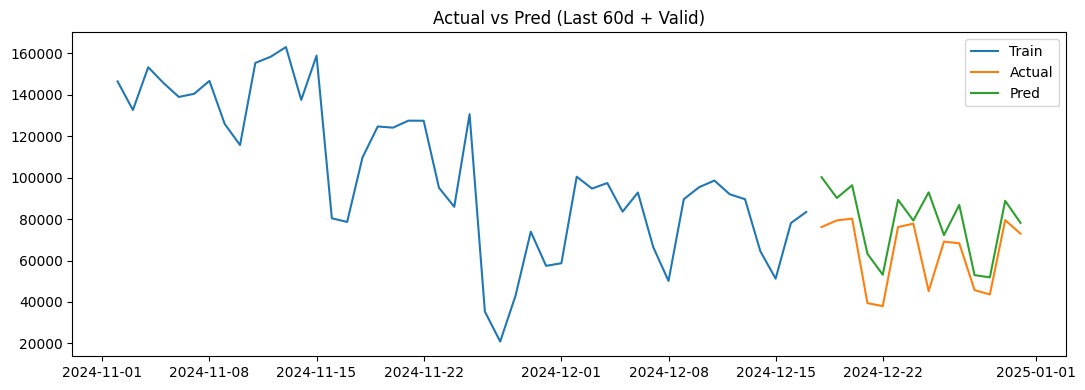

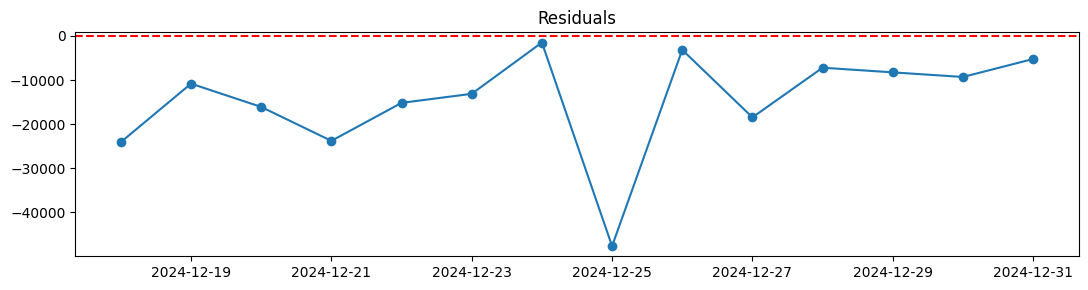

In [66]:
plt.figure(figsize = (11, 4))
plt.plot(y.index[-60:-14], y[-60:-14], label = "Train")
plt.plot(val_y.index, val_y, label = "Actual")
plt.plot(pred_val.index, pred_val, label = "Pred")
plt.title("Actual vs Pred (Last 60d + Valid)")
plt.legend()
plt.tight_layout()
plt.show()

resid = val_y - pred_val
plt.figure(figsize = (11, 3))
plt.plot(resid.index, resid, marker = "o")
plt.axhline(0, color = "r", ls = "--")
plt.title("Residuals")
plt.tight_layout()
plt.show()

In [ ]:
# 그래프 해석
# 전체 추세는 잘 따라가지만 검증 구간 초반과 12/25 전후에서 예측이 실제보다 높게 나왔음. 특히 12/25 근처에서 가장 큰 차이를 보임
    # -> 휴일/연말 효과 반영 못해서 과예측이 발생함

# 인사이트
    # 패턴 : 주중/주말/연말에 수요레벨이 점점 내려감 -> 요일 더미만으로 부족, 공휴일 플래그가 필요
    # 바이어스 : 검증 구간 전반에 예측이 약간 위쪽 -> 로그 변환으로 분산 안정화하면 MAPE가 보통 개선
    # 이상치 : 12/25 구간에 큰 음의 잔차 -> 휴일 가중치나 Robust 회귀가 유리

In [65]:
# 공휴일/주말 피처 추가
!pip install holidays

In [67]:
import holidays

kr_holidays = holidays.KR()

idx = y.index
feat = pd.DataFrame(index = idx)
feat["lag1"] = y.shift(1)
feat["ma7"] = y.rolling(7).mean().shift(1)

feat["is_weekend"] = (idx.dayofweek >= 5).astype(int)
feat["is_holiday"] = idx.to_series().apply(lambda d: int(d in kr_holidays)).values

feat["month_sin"] = np.sin(2 * np.pi + idx.month / 12)
feat["month_cos"] = np.cos(2 * np.pi + idx.month / 12)

In [68]:
val_idx = val_y.index
X_train = feat.loc[:val_idx.min() - pd.Timedelta(days = 1)].dropna()
y_train = y.loc[X_train.index]
X_val = feat.loc[val_idx]

In [69]:
from sklearn.linear_model import Ridge

y_train_log = np.log1p(y_train)
model = Ridge(alpha = 1.0, random_state = 42)
model.fit(X_train, y_train_log)
pred_val = pd.Series(np.expm1(model.predict(X_val)), index = val_idx).clip(lower = 0)

In [70]:
m = metrics_safe(val_y, pred_val)
print(f"Model(log + Ridge) -> MAE:{m[0]:.2f}, RMSE:{m[1]:.2f}, MAPE:{m[2]:.2f}%")

b_naive = metrics_safe(val_y, naive_pred)
b_ma7 = metrics_safe(val_y, ma7_pred)
rmse_base = min(b_naive[1], b_ma7[1])
print(f"개선율(RMSE): {((rmse_base - m[1]) / rmse_base * 100):.1f}%")

Model(log + Ridge) -> MAE:13416.69, RMSE:259305351.96, MAPE:26.96%
개선율(RMSE): 6.2%


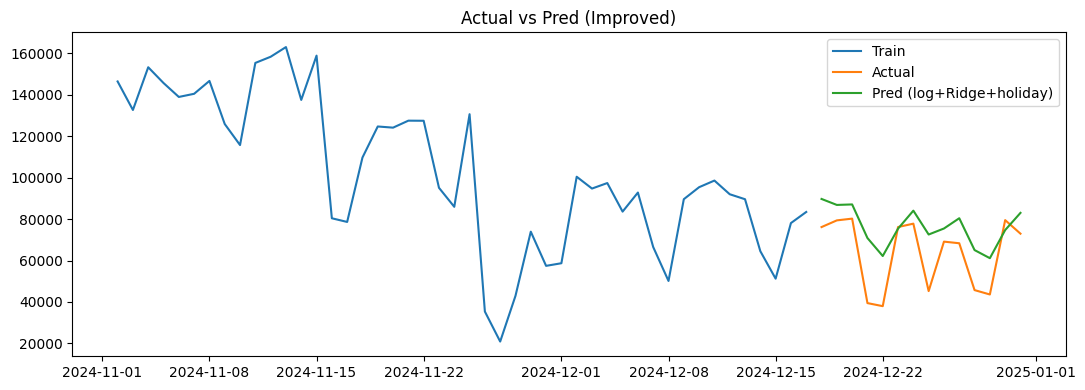

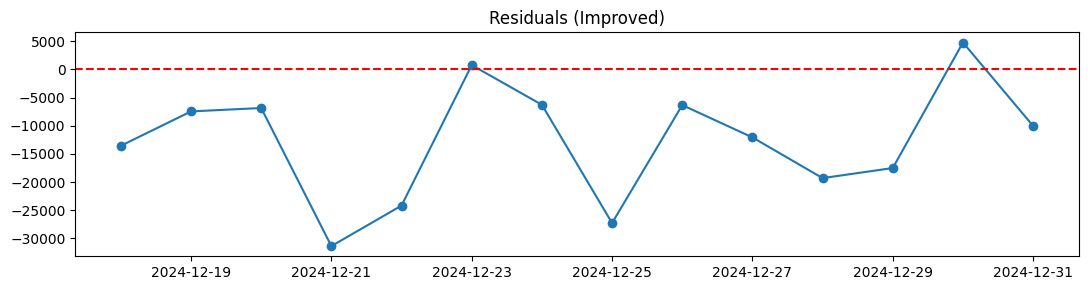

In [73]:
plt.figure(figsize=(11,4))
plt.plot(y.index[-60:-14], y[-60:-14], label='Train')
plt.plot(val_y.index, val_y, label='Actual')
plt.plot(pred_val.index, pred_val, label='Pred (log+Ridge+holiday)')
plt.title('Actual vs Pred (Improved)'); plt.legend(); plt.tight_layout(); plt.show()

resid = val_y - pred_val
plt.figure(figsize=(11,3))
plt.plot(resid.index, resid, marker='o'); plt.axhline(0, color='r', ls='--')
plt.title('Residuals (Improved)'); plt.tight_layout(); plt.show()

In [75]:
# 옵션 : HuberRegressor로 바꾸기
from sklearn.linear_model import HuberRegressor

model = HuberRegressor(epsilon = 1.5)
model.fit(X_train, y_train)
pred_val = pd.Series(model.predict(X_val), index = val_idx).clip(lower = 0)
metrics_safe(val_y, pred_val)

(13752.111508891332, 335174231.2321344, np.float64(27.424752786589284))

In [ ]:
# feat["med30"] = y.rolling(30).median().shift(1)

In [76]:
print('기간:', y.index.min(), '→', y.index.max(), '샘플:', y.shape[0])
print(f'Naive -> MAE:{b_naive[0]:.2f}, RMSE:{b_naive[1]:.2f}, MAPE:{b_naive[2]:.2f}%')
print(f'MA(7) -> MAE:{b_ma7[0]:.2f}, RMSE:{b_ma7[1]:.2f}, MAPE:{b_ma7[2]:.2f}%')
print(f'Model -> MAE:{m_lin[0]:.2f}, RMSE:{m_lin[1]:.2f}, MAPE:{m_lin[2]:.2f}%')

rmse_base = min(b_naive[1], b_ma7[1])
impr = (rmse_base - m_lin[1]) / rmse_base * 100
print(f'개선율(RMSE): {impr:.1f}%')

기간: 2024-06-01 00:00:00 → 2024-12-31 00:00:00 샘플: 214
Naive -> MAE:15548.36, RMSE:475606592.21, MAPE:27.86%
MA(7) -> MAE:13714.71, RMSE:276553892.96, MAPE:27.38%
Model -> MAE:14562.13, RMSE:341542800.40, MAPE:26.81%
개선율(RMSE): -23.5%


In [77]:
val_idx = val_y.index
print(naive_pred.index.equals(val_idx), ma7_pred.index.equals(val_idx), pred_val.index.equals(val_idx))

True True True


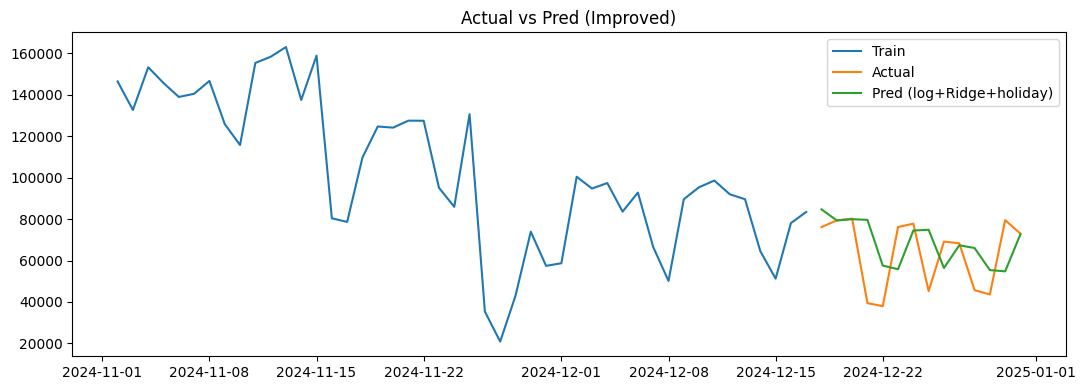

In [78]:
plt.figure(figsize=(11,4))
plt.plot(y.index[-60:-14], y[-60:-14], label='Train')
plt.plot(val_y.index, val_y, label='Actual')
plt.plot(pred_val.index, pred_val, label='Pred (log+Ridge+holiday)')
plt.title('Actual vs Pred (Improved)'); plt.legend(); plt.tight_layout()
plt.savefig('actual_vs_pred.png', dpi=140, bbox_inches='tight')
plt.show()

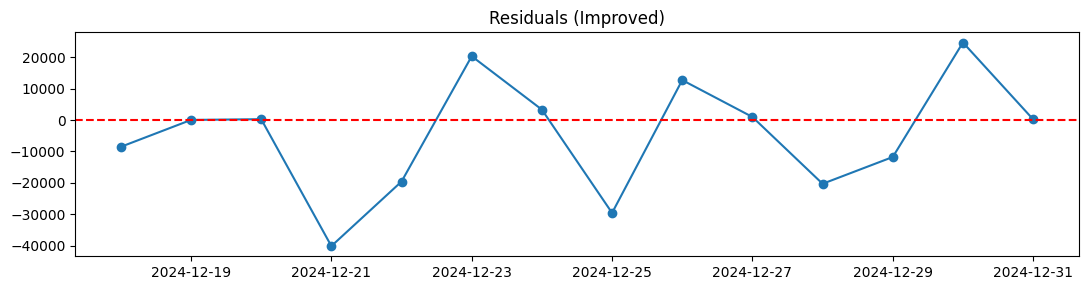

In [79]:
plt.figure(figsize=(11,3))
resid = val_y - pred_val
plt.plot(resid.index, resid, marker='o')
plt.axhline(0, color='r', ls='--')
plt.title('Residuals (Improved)'); plt.tight_layout()
plt.savefig('residuals.png', dpi=140, bbox_inches='tight')
plt.show()

In [80]:
def metrics_rmse(y_true, y_pred):
    yt, yp = y_true.align(y_pred, join='inner')
    m = yt.notna() & yp.notna()
    yt, yp = yt[m].astype('float64'), yp[m].astype('float64')
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp)  # RMSE
    eps  = 1e-9
    mape = (np.abs((yt - yp) / yt.replace(0, eps))).mean() * 100
    return mae, rmse, mape

b_naive = metrics_rmse(val_y, naive_pred)
b_ma7   = metrics_rmse(val_y, ma7_pred)
m_lin   = metrics_rmse(val_y, pred_val)

rmse_base = min(b_naive[1], b_ma7[1])
impr = (rmse_base - m_lin[1]) / rmse_base * 100

print(f'Naive -> MAE:{b_naive[0]:.2f}, RMSE:{b_naive[1]:.2f}, MAPE:{b_naive[2]:.2f}%')
print(f'MA(7) -> MAE:{b_ma7[0]:.2f}, RMSE:{b_ma7[1]:.2f}, MAPE:{b_ma7[2]:.2f}%')
print(f'Model -> MAE:{m_lin[0]:.2f}, RMSE:{m_lin[1]:.2f}, MAPE:{m_lin[2]:.2f}%')
print(f'개선율(RMSE): {impr:.1f}%')

Naive -> MAE:15548.36, RMSE:475606592.21, MAPE:27.86%
MA(7) -> MAE:13714.71, RMSE:276553892.96, MAPE:27.38%
Model -> MAE:13752.11, RMSE:335174231.23, MAPE:27.42%
개선율(RMSE): -21.2%
